In [25]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
def f(x):
  return 3*x**2 - 4*x + 5

f(3.0)

20.0

In [27]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

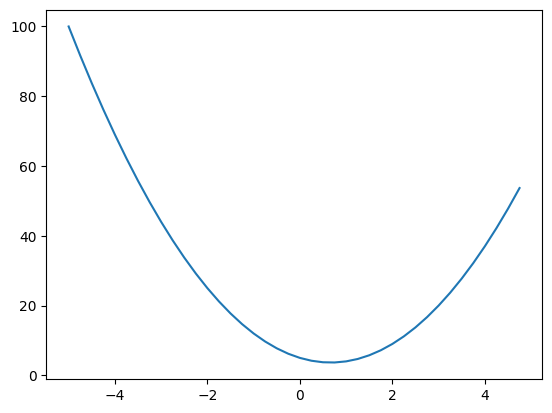

In [28]:
plt.plot(xs, ys)

In [29]:
print(xs)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


In [30]:
x = 3
h = 0.0000000001
print((f(x+h)-f(x))/h)

14.000001158365194


In [31]:
x = 2/3
h = 0.0000000001
print((f(x+h)-f(x))/h)

0.0


In [32]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [33]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
          self.grad += 1.0 * out.grad
          other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
            
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out
      
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
             
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
    
        def _backward():
          self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

In [34]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10, label="c")
e = a*b; e.label= "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label = "L"
L

Value(data=-8.0)

In [35]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


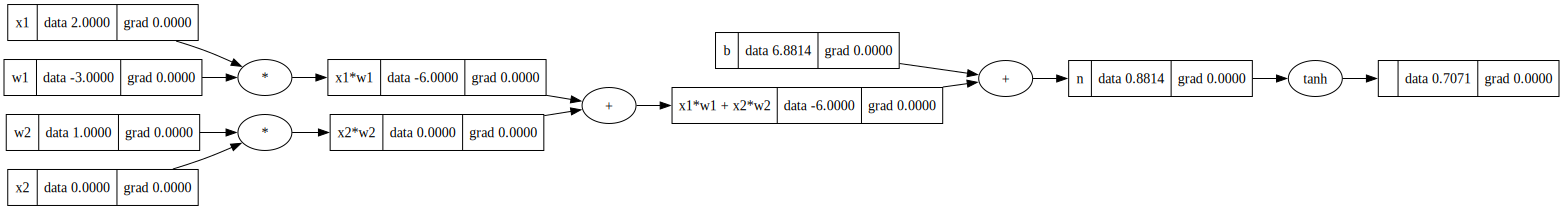

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)

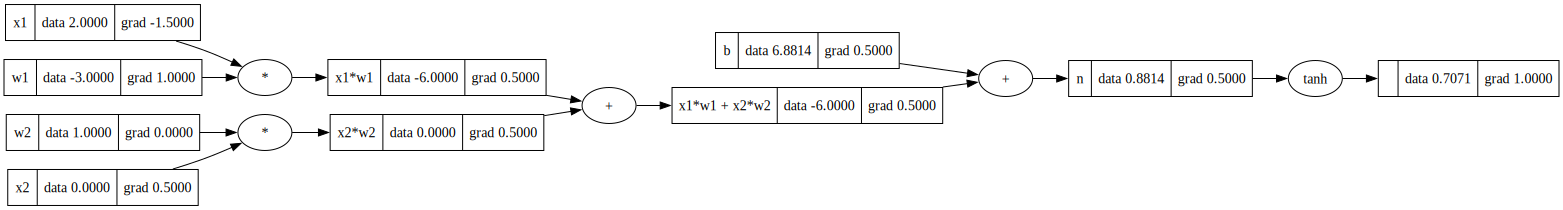

In [37]:
o.backward()
draw_dot(o)


In [38]:
a = Value(2.0)
b = 2
a**b

Value(data=4.0)

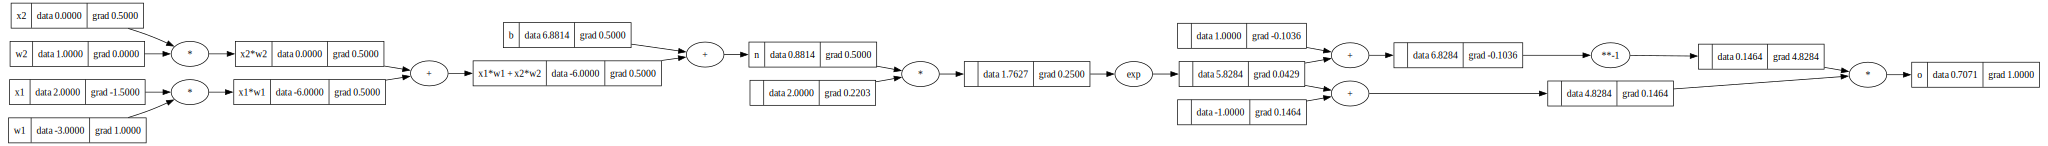

In [39]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [40]:
import torch

In [41]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [158]:
import random 
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]        

In [157]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=0.9962374005913387),
 Value(data=-0.9655386615845155),
 Value(data=-0.997243585296721)]

In [204]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.10797375372012026)

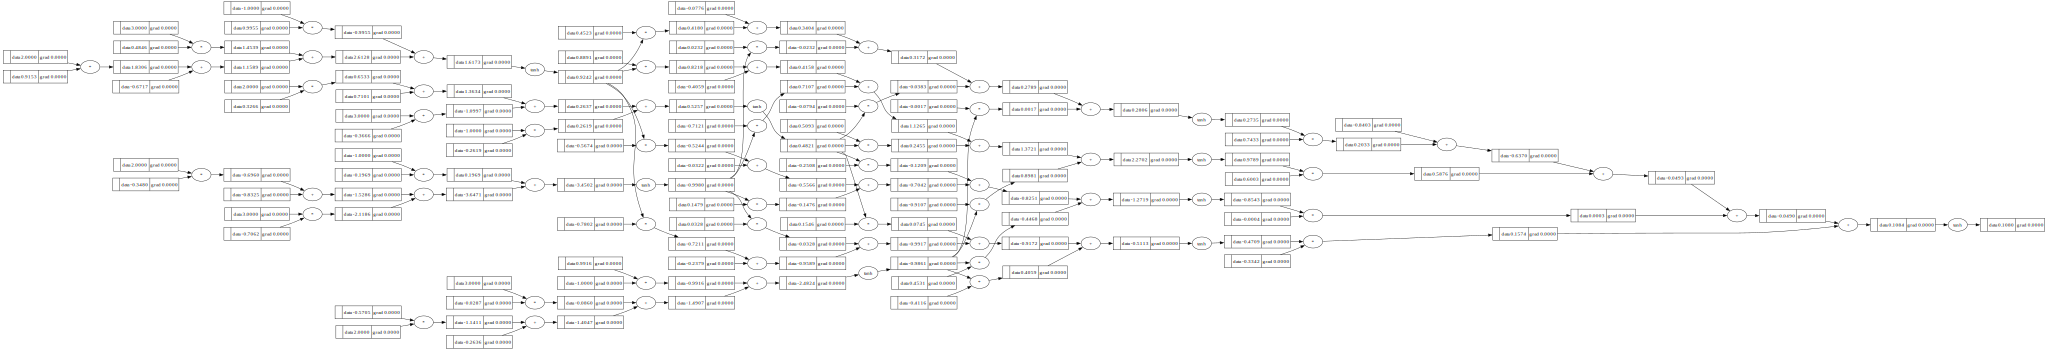

In [206]:
draw_dot(n(x))

In [207]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 

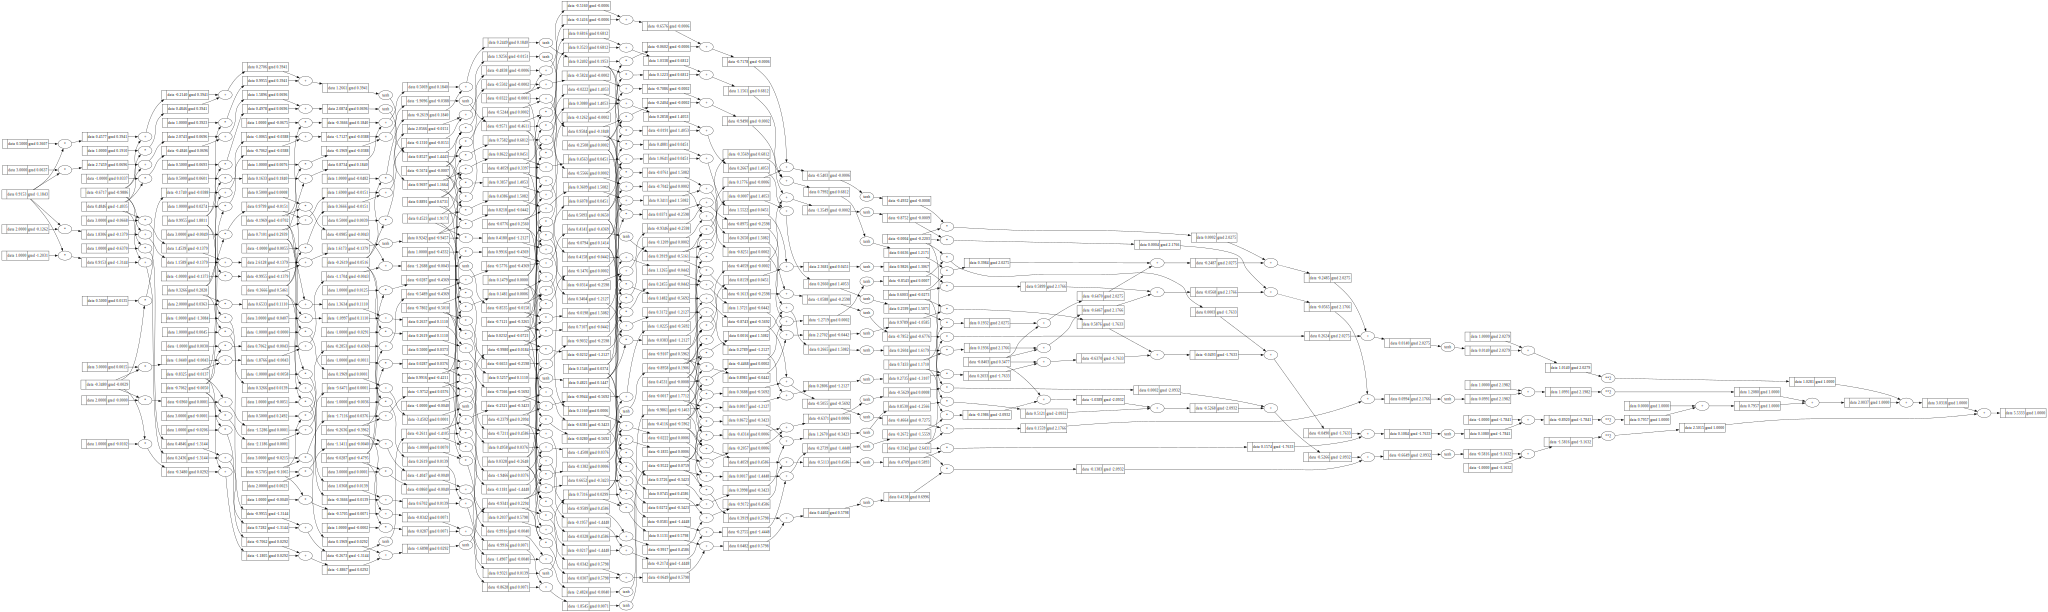

In [213]:
 # forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()
draw_dot(loss)

In [214]:
 ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.533336140536395)

In [215]:
n.parameters()


[Value(data=0.9153164378506844),
 Value(data=0.48461979039166003),
 Value(data=0.9955029660760641),
 Value(data=-0.6716894636023678),
 Value(data=-0.34801258019438563),
 Value(data=-0.7061872471755106),
 Value(data=-0.19692422016001943),
 Value(data=-0.8325275520462609),
 Value(data=0.326627780524507),
 Value(data=-0.36655551753051285),
 Value(data=-0.26194015455041675),
 Value(data=0.7101286408545486),
 Value(data=-0.5705485605011722),
 Value(data=-0.028679296452063685),
 Value(data=0.9916306825910126),
 Value(data=-0.26360314754269965),
 Value(data=0.4522626002633805),
 Value(data=0.023217081751806923),
 Value(data=-0.07943155005375879),
 Value(data=-0.0017340737805022766),
 Value(data=-0.07763909758441057),
 Value(data=0.8891331336274408),
 Value(data=-0.7121449938539273),
 Value(data=0.5093295364050234),
 Value(data=-0.9107499768077849),
 Value(data=-0.405933100091205),
 Value(data=-0.5674087443186571),
 Value(data=0.1479160571399536),
 Value(data=-0.2508488475494477),
 Value(data=

In [217]:
for p in n.parameters():
    p.grad = 0.0
loss.backward()

In [218]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward() # updates the grad using chain rule
  
  # update params based on the gradient
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 5.533336140536395
1 3.8471706357622173
2 3.6367000583773557
3 3.3915266674910374
4 3.143200365964482
5 1.9612852127212677
6 0.9598007391553169
7 0.2215601068727533
8 0.07278459513954696
9 0.058041750309895404
10 0.048876517033332886
11 0.04242482397637448
12 0.037558203397810214
13 0.03372413216122208
14 0.030611536958317975
15 0.028027919333314243
16 0.025845967823411503
17 0.023977287119385224
18 0.022358190852542172
19 0.02094143976484319


In [219]:
 ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.019691157108258153)

In [220]:
ypred

[Value(data=0.9286080530179495),
 Value(data=-0.9398756422068466),
 Value(data=-0.944241090328581),
 Value(data=0.9112849922133485)]